# 📊 Datathon FIAP - Passos Mágicos
## Notebook 03 — Modelo Preditivo de Risco de Defasagem

Este notebook desenvolve um **modelo preditivo** para identificar alunos em risco de defasagem escolar,
utilizando dados do PEDE (Pesquisa Extensiva do Desenvolvimento Educacional) de 2022, 2023 e 2024.

**Abordagem:**
- Algoritmo: **Gradient Boosting Classifier**
- Target: Classificação binária (Sem Risco vs Com Risco de defasagem)
- Saída: Probabilidade de risco com 4 níveis (Sem Risco, Atenção, Risco Moderado, Risco Alto)
- Validação: Split 80/20 estratificado + Stratified K-Fold (5 folds)
- Dataset: 2.467 registros, 11 features (sem Inglês — apenas 33% de preenchimento)

## 1. Configuração do Ambiente

In [1]:
# Baixar dados do GitHub (executar apenas no Google Colab)
import urllib.request
import os

os.makedirs('data', exist_ok=True)
url = 'https://raw.githubusercontent.com/LeandroCrespo/datathon-passos-magicos/main/data/BASE_DE_DADOS_PEDE_2024_DATATHON.xlsx'
dest = 'data/BASE_DE_DADOS_PEDE_2024_DATATHON.xlsx'

if not os.path.exists(dest):
    print('⬇️ Baixando dados...')
    urllib.request.urlretrieve(url, dest)
    print('✅ Dados baixados com sucesso!')
else:
    print('✅ Dados já existem localmente.')

⬇️ Baixando dados...
✅ Dados baixados com sucesso!


In [2]:
# Instalar bibliotecas necessárias
!pip install openpyxl scikit-learn -q
print('✅ Bibliotecas instaladas')

✅ Bibliotecas instaladas


In [3]:
# Importar bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (accuracy_score, roc_auc_score, f1_score, 
                             classification_report, confusion_matrix, 
                             roc_curve, precision_recall_curve)

plt.style.use('seaborn-v0_8-whitegrid')
print('✅ Bibliotecas importadas')

✅ Bibliotecas importadas


## 2. Carregamento e Preparação dos Dados

Carregamos as 3 planilhas (PEDE 2022, 2023 e 2024) e padronizamos os nomes das colunas,
que variam entre os anos (ex: "Matem" em 2022 vs "Mat" em 2023/2024).

**Decisão importante:** Removemos a feature **Inglês (ING)** porque ela possui apenas 33% de 
preenchimento em 2022 e é escassa nos demais anos. Mantê-la reduziria o dataset de ~2.400 para 
~660 registros, sacrificando 75% dos dados por uma feature com importância de apenas ~5%.

In [4]:
# Carregar dados
CAMINHO_ARQUIVO = 'data/BASE_DE_DADOS_PEDE_2024_DATATHON.xlsx'
xlsx = pd.ExcelFile(CAMINHO_ARQUIVO)
print(f'📋 Planilhas disponíveis: {xlsx.sheet_names}')

all_data = []
for sheet in xlsx.sheet_names:
    df_year = pd.read_excel(xlsx, sheet_name=sheet)
    year = sheet.replace('PEDE', '')
    
    # Padronizar nomes de colunas (variam entre anos)
    rename = {}
    for c in df_year.columns:
        cl = c.strip()
        if cl == 'Idade 22' or cl == 'Idade': rename[c] = 'IDADE'
        elif cl == 'Matem' or cl == 'Mat': rename[c] = 'MAT'
        elif cl == 'Portug' or cl == 'Por': rename[c] = 'POR'
        elif cl in ['Defas', 'Defasagem']: rename[c] = 'DEFASAGEM'
        elif 'Gênero' in cl: rename[c] = 'GÊNERO'
        elif 'Instituição' in cl: rename[c] = 'INSTITUIÇÃO DE ENSINO'
        elif cl == 'Ano ingresso': rename[c] = 'ANO INGRESSO'
    
    df_year = df_year.rename(columns=rename)
    df_year['ANO_PEDE'] = int(year)
    all_data.append(df_year)
    print(f'  {sheet}: {len(df_year)} registros')

df = pd.concat(all_data, ignore_index=True)
print(f'\n📊 Total: {len(df)} registros')

📋 Planilhas disponíveis: ['PEDE2022', 'PEDE2023', 'PEDE2024']


  PEDE2022: 860 registros


  PEDE2023: 1014 registros


  PEDE2024: 1156 registros

📊 Total: 3030 registros


In [5]:
# Definir features
# NOTA: Excluímos INDE e IAN (evitar data leakage) e ING (baixo preenchimento)
features_numericas = ['IDA', 'IEG', 'IAA', 'IPS', 'IPV', 'IDADE', 'ANO INGRESSO', 'MAT', 'POR']
features_categoricas = ['GÊNERO', 'INSTITUIÇÃO DE ENSINO']

# Converter numéricas
for col in features_numericas:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Converter categóricas
le_dict = {}
for col in features_categoricas:
    if col in df.columns:
        df[col] = df[col].fillna('Desconhecido')
        le = LabelEncoder()
        df[col + '_ENC'] = le.fit_transform(df[col].astype(str))
        le_dict[col] = le
        print(f'{col}: {dict(zip(le.classes_, range(len(le.classes_))))}')

print('\n✅ Features preparadas')

GÊNERO: {'Feminino': 0, 'Masculino': 1, 'Menina': 2, 'Menino': 3}
INSTITUIÇÃO DE ENSINO: {'Bolsista Universitário *Formado (a)': 0, 'Concluiu o 3º EM': 1, 'Desconhecido': 2, 'Escola JP II': 3, 'Escola Pública': 4, 'Nenhuma das opções acima': 5, 'Privada': 6, 'Privada *Parcerias com Bolsa 100%': 7, 'Privada - Pagamento por *Empresa Parceira': 8, 'Privada - Programa de Apadrinhamento': 9, 'Privada - Programa de apadrinhamento': 10, 'Pública': 11, 'Rede Decisão': 12}

✅ Features preparadas


## 3. Definição da Variável Alvo

A **defasagem escolar** é calculada como: `Defasagem = Fase Real - Fase Ideal`

| Defasagem | Classificação |
|-----------|---------------|
| ≥ 0 | **Sem Risco** (na fase certa ou adiantado) |
| < 0 | **Com Risco** (atrasado em relação à fase ideal) |

Além da classificação binária, utilizamos a **probabilidade** do modelo para criar 4 níveis de risco:

| Probabilidade | Nível |
|---------------|-------|
| < 30% | Sem Risco |
| 30% - 60% | Atenção |
| 60% - 85% | Risco Moderado |
| > 85% | Risco Alto |

In [6]:
# Criar variável alvo
df['DEFASAGEM'] = pd.to_numeric(df['DEFASAGEM'], errors='coerce')

def classificar_risco(d):
    if pd.isna(d): return None
    return 1 if d < 0 else 0  # 1 = Com Risco, 0 = Sem Risco

df['CLASSE_RISCO'] = df['DEFASAGEM'].apply(classificar_risco)

# Selecionar features disponíveis
features_final = features_numericas.copy()
for col in features_categoricas:
    if col + '_ENC' in df.columns:
        features_final.append(col + '_ENC')

print(f'Features utilizadas ({len(features_final)}): {features_final}')

# Remover linhas com valores nulos
df_model = df.dropna(subset=['CLASSE_RISCO'] + features_final).copy()
df_model['CLASSE_RISCO'] = df_model['CLASSE_RISCO'].astype(int)

print(f'\nRegistros válidos: {len(df_model)}')
print(f'  Sem Risco (0): {(df_model["CLASSE_RISCO"]==0).sum()} ({(df_model["CLASSE_RISCO"]==0).mean()*100:.1f}%)')
print(f'  Com Risco (1): {(df_model["CLASSE_RISCO"]==1).sum()} ({(df_model["CLASSE_RISCO"]==1).mean()*100:.1f}%)')

Features utilizadas (11): ['IDA', 'IEG', 'IAA', 'IPS', 'IPV', 'IDADE', 'ANO INGRESSO', 'MAT', 'POR', 'GÊNERO_ENC', 'INSTITUIÇÃO DE ENSINO_ENC']

Registros válidos: 2467
  Sem Risco (0): 1014 (41.1%)
  Com Risco (1): 1453 (58.9%)


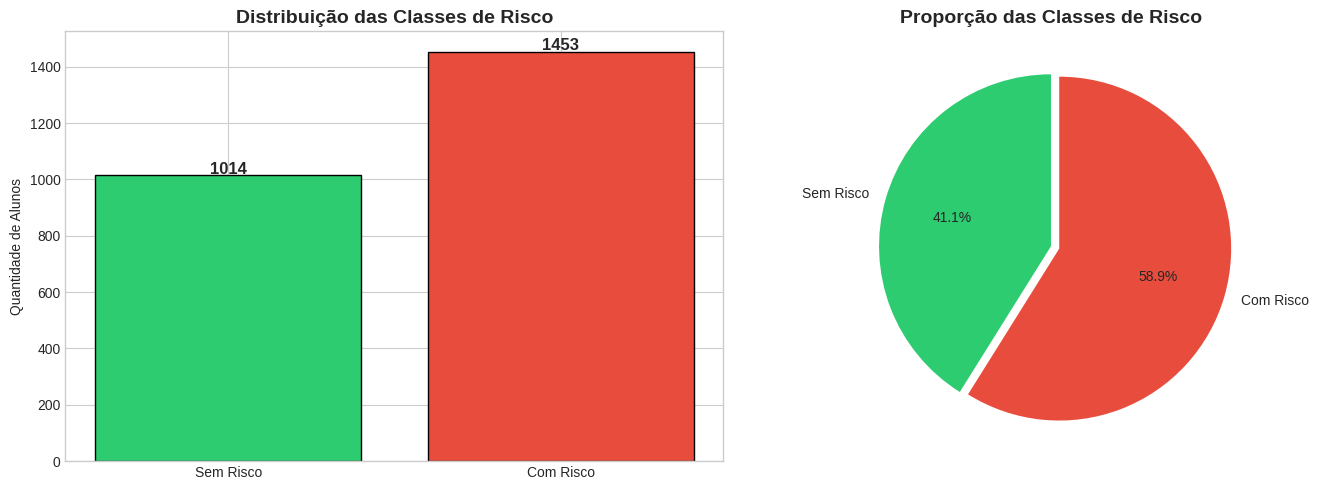

In [7]:
# Visualizar distribuição
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
cores = ['#2ecc71', '#e74c3c']
labels = ['Sem Risco', 'Com Risco']
valores = df_model['CLASSE_RISCO'].value_counts().sort_index()

bars = axes[0].bar(labels, valores.values, color=cores, edgecolor='black')
axes[0].set_title('Distribuição das Classes de Risco', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Quantidade de Alunos')
for bar, val in zip(bars, valores.values):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
                 f'{val}', ha='center', fontsize=12, fontweight='bold')

axes[1].pie(valores.values, labels=labels, colors=cores, autopct='%1.1f%%', 
            startangle=90, explode=(0, 0.05))
axes[1].set_title('Proporção das Classes de Risco', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

## 4. Análise dos Padrões de Risco

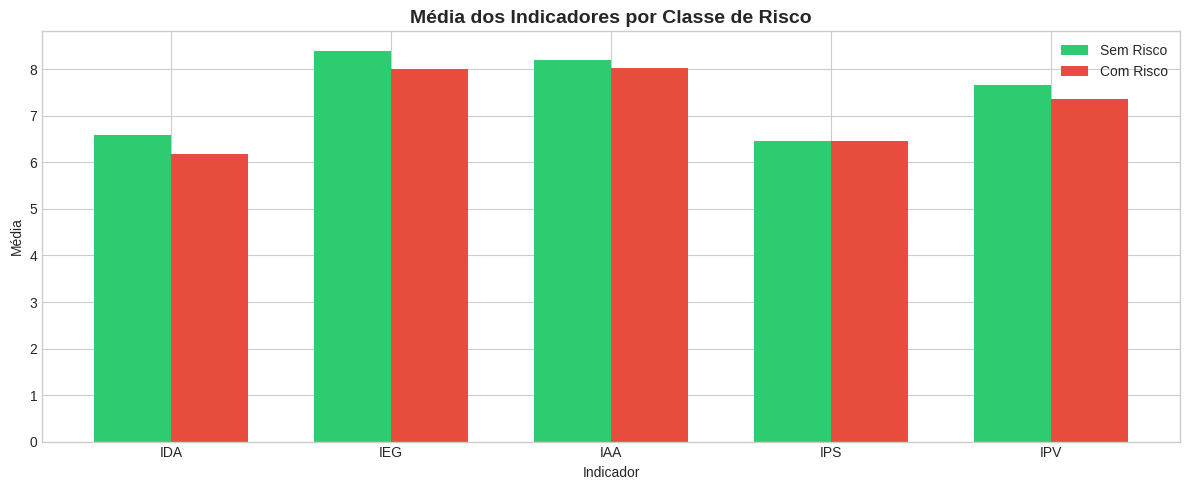

            IDA   IEG   IAA   IPS   IPV
Sem Risco  6.60  8.40  8.20  6.47  7.67
Com Risco  6.19  8.01  8.04  6.47  7.36


In [8]:
# Média dos indicadores por classe
indicadores = ['IDA', 'IEG', 'IAA', 'IPS', 'IPV']
media_por_classe = df_model.groupby('CLASSE_RISCO')[indicadores].mean()
media_por_classe.index = ['Sem Risco', 'Com Risco']

fig, ax = plt.subplots(figsize=(12, 5))
x = np.arange(len(indicadores))
width = 0.35
bars1 = ax.bar(x - width/2, media_por_classe.loc['Sem Risco'], width, label='Sem Risco', color='#2ecc71')
bars2 = ax.bar(x + width/2, media_por_classe.loc['Com Risco'], width, label='Com Risco', color='#e74c3c')
ax.set_xlabel('Indicador')
ax.set_ylabel('Média')
ax.set_title('Média dos Indicadores por Classe de Risco', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(indicadores)
ax.legend()
plt.tight_layout()
plt.show()

print(media_por_classe.round(2))

## 5. Preparação dos Dados para Modelagem

Utilizamos **split 80/20 estratificado por ano e classe** para garantir que cada conjunto
(treino e teste) tenha proporção representativa de cada ano (2022, 2023, 2024) e de cada classe.

In [9]:
# Separar features e target
X = df_model[features_final].values
y = df_model['CLASSE_RISCO'].values

# Split estratificado por ano + classe
df_model['STRAT'] = df_model['ANO_PEDE'].astype(str) + '_' + df_model['CLASSE_RISCO'].astype(str)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=df_model['STRAT'].values
)

print(f'Shape X: {X.shape}')
print(f'Treino: {len(X_train)} ({len(X_train)/len(X)*100:.0f}%)')
print(f'Teste:  {len(X_test)} ({len(X_test)/len(X)*100:.0f}%)')

# Normalizar
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print('\n✅ Dados preparados e normalizados')

Shape X: (2467, 11)
Treino: 1973 (80%)
Teste:  494 (20%)

✅ Dados preparados e normalizados


## 6. Comparação de Modelos de Machine Learning

Testamos 4 algoritmos para selecionar o mais adequado ao problema.

In [10]:
# Definir modelos
modelos = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'SVM (RBF)': SVC(kernel='rbf', probability=True, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=200, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=200, max_depth=4, learning_rate=0.1,
        min_samples_split=10, min_samples_leaf=5, subsample=0.8, random_state=42
    ),
}

# Treinar e avaliar cada modelo
resultados = []
print('='*70)
print('TREINAMENTO E AVALIAÇÃO DOS MODELOS')
print('='*70)

for nome, modelo in modelos.items():
    modelo.fit(X_train_scaled, y_train)
    y_pred = modelo.predict(X_test_scaled)
    y_proba = modelo.predict_proba(X_test_scaled)[:, 1]
    
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)
    f1 = f1_score(y_test, y_pred)
    
    resultados.append({
        'Modelo': nome,
        'Acurácia': acc,
        'AUC-ROC': auc,
        'F1-Score': f1,
        'modelo_obj': modelo
    })
    print(f'  {nome:25s} | Acc={acc*100:.1f}% | AUC={auc*100:.1f}% | F1={f1*100:.1f}%')

df_resultados = pd.DataFrame(resultados)
print('\n✅ Todos os modelos treinados')

TREINAMENTO E AVALIAÇÃO DOS MODELOS
  Logistic Regression       | Acc=60.3% | AUC=64.1% | F1=69.9%


  SVM (RBF)                 | Acc=68.2% | AUC=74.3% | F1=75.7%


  Random Forest             | Acc=75.3% | AUC=82.7% | F1=80.4%


  Gradient Boosting         | Acc=78.7% | AUC=86.2% | F1=82.7%

✅ Todos os modelos treinados


In [11]:
# Ranking dos modelos
df_ranking = df_resultados[['Modelo', 'Acurácia', 'AUC-ROC', 'F1-Score']].sort_values('Acurácia', ascending=False)
df_ranking['Acurácia'] = df_ranking['Acurácia'].apply(lambda x: f'{x*100:.1f}%')
df_ranking['AUC-ROC'] = df_ranking['AUC-ROC'].apply(lambda x: f'{x*100:.1f}%')
df_ranking['F1-Score'] = df_ranking['F1-Score'].apply(lambda x: f'{x*100:.1f}%')
print('\n🏆 RANKING DOS MODELOS:')
print(df_ranking.to_string(index=False))


🏆 RANKING DOS MODELOS:
             Modelo Acurácia AUC-ROC F1-Score
  Gradient Boosting    78.7%   86.2%    82.7%
      Random Forest    75.3%   82.7%    80.4%
          SVM (RBF)    68.2%   74.3%    75.7%
Logistic Regression    60.3%   64.1%    69.9%


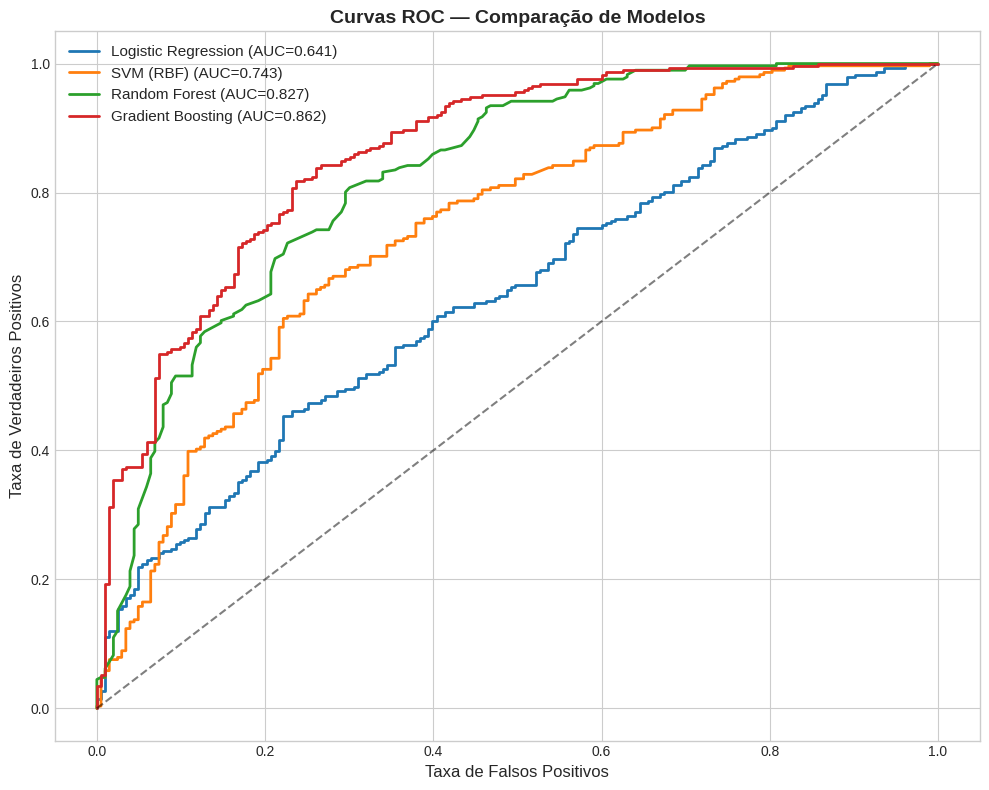

In [12]:
# Curvas ROC
plt.figure(figsize=(10, 8))
for res in resultados:
    modelo = res['modelo_obj']
    y_proba = modelo.predict_proba(X_test_scaled)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f'{res["Modelo"]} (AUC={res["AUC-ROC"]:.3f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.xlabel('Taxa de Falsos Positivos', fontsize=12)
plt.ylabel('Taxa de Verdadeiros Positivos', fontsize=12)
plt.title('Curvas ROC — Comparação de Modelos', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.tight_layout()
plt.show()

## 7. Análise do Modelo Escolhido: Gradient Boosting

O **Gradient Boosting** foi selecionado como modelo final por apresentar o melhor equilíbrio entre
acurácia, AUC-ROC e F1-Score. Além disso, oferece feature importance nativa e probabilidades
calibradas para a criação dos níveis de risco.

In [13]:
# Modelo escolhido
gb = modelos['Gradient Boosting']
y_pred_final = gb.predict(X_test_scaled)
y_proba_final = gb.predict_proba(X_test_scaled)[:, 1]

print('='*70)
print('MODELO ESCOLHIDO: GRADIENT BOOSTING')
print('='*70)
print(f'\nAcurácia: {accuracy_score(y_test, y_pred_final)*100:.1f}%')
print(f'AUC-ROC:  {roc_auc_score(y_test, y_proba_final)*100:.1f}%')
print(f'F1-Score: {f1_score(y_test, y_pred_final)*100:.1f}%')
print(f'\n{classification_report(y_test, y_pred_final, target_names=["Sem Risco", "Com Risco"])}')

MODELO ESCOLHIDO: GRADIENT BOOSTING

Acurácia: 78.7%
AUC-ROC:  86.2%
F1-Score: 82.7%

              precision    recall  f1-score   support

   Sem Risco       0.78      0.68      0.72       203
   Com Risco       0.79      0.86      0.83       291

    accuracy                           0.79       494
   macro avg       0.78      0.77      0.78       494
weighted avg       0.79      0.79      0.78       494



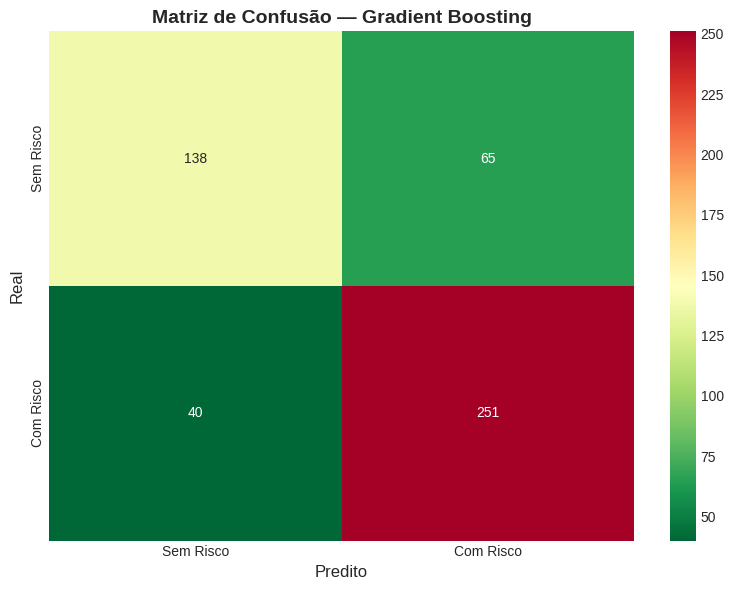

In [14]:
# Matriz de Confusão
fig, ax = plt.subplots(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_final)
sns.heatmap(cm, annot=True, fmt='d', cmap='RdYlGn_r', 
            xticklabels=['Sem Risco', 'Com Risco'],
            yticklabels=['Sem Risco', 'Com Risco'], ax=ax)
ax.set_xlabel('Predito', fontsize=12)
ax.set_ylabel('Real', fontsize=12)
ax.set_title('Matriz de Confusão — Gradient Boosting', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 8. Validação Cruzada (Stratified K-Fold)

Utilizamos **Stratified K-Fold com 5 folds** para validar a robustez do modelo.
Esta estratégia garante que cada fold mantenha a mesma proporção de classes,
evitando a instabilidade observada no CV padrão.

In [15]:
# Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_accs, cv_aucs, cv_f1s = [], [], []

print('='*70)
print('STRATIFIED K-FOLD (5 folds)')
print('='*70)

for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), 1):
    sc = StandardScaler()
    X_tr = sc.fit_transform(X[train_idx])
    X_te = sc.transform(X[test_idx])
    
    m = GradientBoostingClassifier(
        n_estimators=200, max_depth=4, learning_rate=0.1,
        min_samples_split=10, min_samples_leaf=5, subsample=0.8, random_state=42
    )
    m.fit(X_tr, y[train_idx])
    
    acc = accuracy_score(y[test_idx], m.predict(X_te))
    auc = roc_auc_score(y[test_idx], m.predict_proba(X_te)[:, 1])
    f1 = f1_score(y[test_idx], m.predict(X_te))
    
    cv_accs.append(acc)
    cv_aucs.append(auc)
    cv_f1s.append(f1)
    print(f'  Fold {fold}: Acc={acc*100:.1f}% | AUC={auc*100:.1f}% | F1={f1*100:.1f}%')

print(f'\n📊 Média:')
print(f'  Acurácia: {np.mean(cv_accs)*100:.1f}% (+/- {np.std(cv_accs)*100:.1f}%)')
print(f'  AUC-ROC:  {np.mean(cv_aucs)*100:.1f}% (+/- {np.std(cv_aucs)*100:.1f}%)')
print(f'  F1-Score: {np.mean(cv_f1s)*100:.1f}% (+/- {np.std(cv_f1s)*100:.1f}%)')

STRATIFIED K-FOLD (5 folds)


  Fold 1: Acc=78.3% | AUC=85.2% | F1=82.5%


  Fold 2: Acc=80.2% | AUC=87.1% | F1=83.9%


  Fold 3: Acc=78.9% | AUC=86.1% | F1=82.9%


  Fold 4: Acc=76.7% | AUC=81.4% | F1=81.2%


  Fold 5: Acc=78.3% | AUC=85.5% | F1=82.0%

📊 Média:
  Acurácia: 78.5% (+/- 1.1%)
  AUC-ROC:  85.1% (+/- 1.9%)
  F1-Score: 82.5% (+/- 0.9%)


## 9. Feature Importance

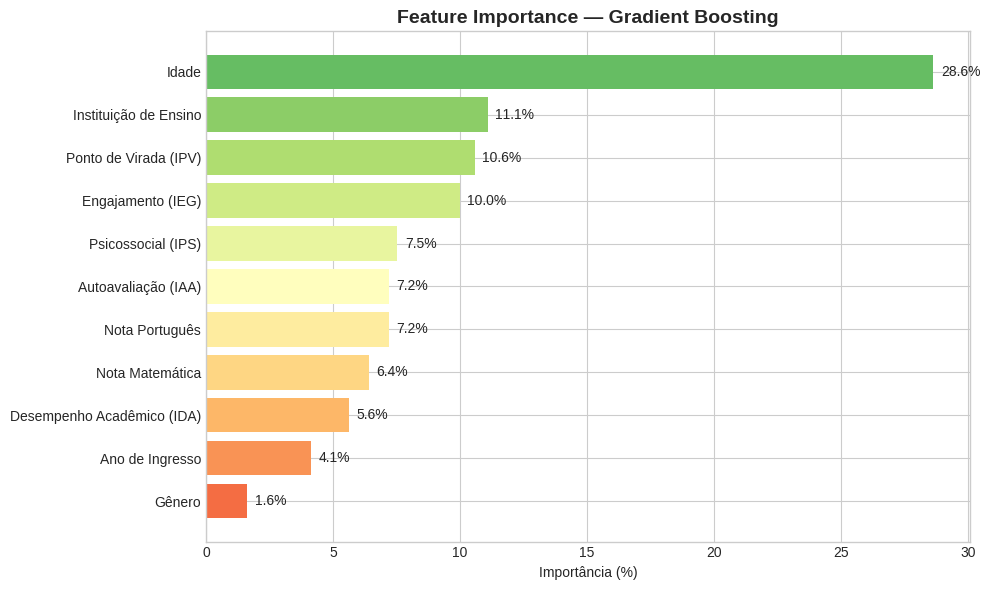


Feature Importance:
  Idade                               28.6%
  Instituição de Ensino               11.1%
  Ponto de Virada (IPV)               10.6%
  Engajamento (IEG)                   10.0%
  Psicossocial (IPS)                  7.5%
  Autoavaliação (IAA)                 7.2%
  Nota Português                      7.2%
  Nota Matemática                     6.4%
  Desempenho Acadêmico (IDA)          5.6%
  Ano de Ingresso                     4.1%
  Gênero                              1.6%


In [16]:
# Feature Importance nativa do Gradient Boosting
fi = dict(zip(features_final, gb.feature_importances_))
fi_sorted = dict(sorted(fi.items(), key=lambda x: x[1], reverse=True))

# Nomes legíveis
nomes_legíveis = {
    'IDA': 'Desempenho Acadêmico (IDA)',
    'IEG': 'Engajamento (IEG)',
    'IAA': 'Autoavaliação (IAA)',
    'IPS': 'Psicossocial (IPS)',
    'IPV': 'Ponto de Virada (IPV)',
    'IDADE': 'Idade',
    'ANO INGRESSO': 'Ano de Ingresso',
    'MAT': 'Nota Matemática',
    'POR': 'Nota Português',
    'GÊNERO_ENC': 'Gênero',
    'INSTITUIÇÃO DE ENSINO_ENC': 'Instituição de Ensino',
}

fig, ax = plt.subplots(figsize=(10, 6))
features_names = [nomes_legíveis.get(f, f) for f in fi_sorted.keys()]
values = [v * 100 for v in fi_sorted.values()]
colors = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(values)))
bars = ax.barh(range(len(values)), values, color=colors)
ax.set_yticks(range(len(values)))
ax.set_yticklabels(features_names)
ax.set_xlabel('Importância (%)')
ax.set_title('Feature Importance — Gradient Boosting', fontsize=14, fontweight='bold')
ax.invert_yaxis()

for bar, val in zip(bars, values):
    ax.text(bar.get_width() + 0.3, bar.get_y() + bar.get_height()/2, 
            f'{val:.1f}%', va='center', fontsize=10)

plt.tight_layout()
plt.show()

print('\nFeature Importance:')
for feat, imp in fi_sorted.items():
    print(f'  {nomes_legíveis.get(feat, feat):35s} {imp*100:.1f}%')

## 10. Níveis de Risco por Probabilidade

Em vez de apenas classificar como "Com Risco" ou "Sem Risco", utilizamos a **probabilidade**
gerada pelo modelo para criar 4 níveis de risco. Isso permite à Passos Mágicos priorizar
intervenções nos alunos com maior probabilidade de defasagem.

| Probabilidade | Nível | Ação sugerida |
|---------------|-------|---------------|
| < 30% | **Sem Risco** | Acompanhamento normal |
| 30% - 60% | **Atenção** | Monitoramento preventivo |
| 60% - 85% | **Risco Moderado** | Intervenção pedagógica |
| > 85% | **Risco Alto** | Intervenção urgente |

VALIDAÇÃO DOS NÍVEIS DE RISCO
  Sem Risco           :  110 alunos | 10.0% realmente com risco
  Atenção             :  101 alunos | 44.6% realmente com risco
  Risco Moderado      :  135 alunos | 74.8% realmente com risco
  Risco Alto          :  148 alunos | 90.5% realmente com risco


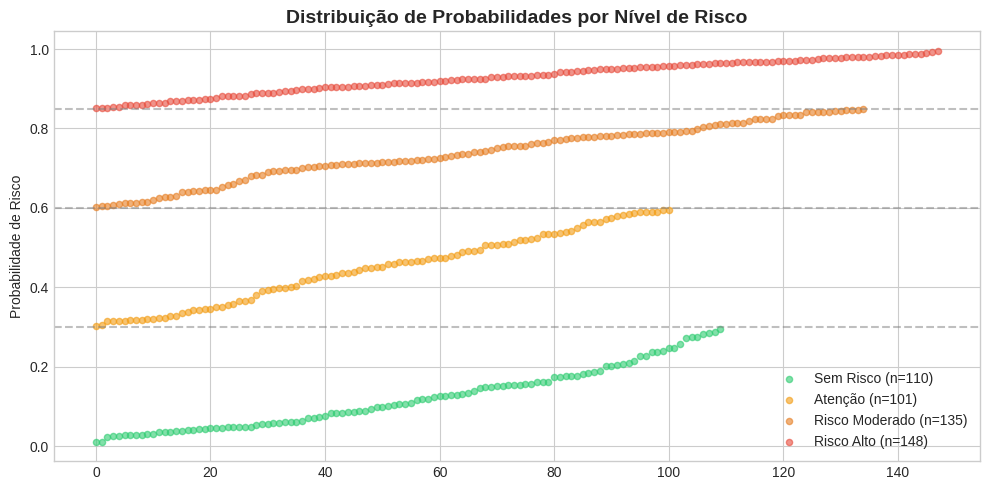

In [17]:
# Classificar níveis de risco
def classificar_nivel_risco(prob):
    if prob < 0.30: return 'Sem Risco'
    elif prob < 0.60: return 'Atenção'
    elif prob < 0.85: return 'Risco Moderado'
    else: return 'Risco Alto'

niveis = [classificar_nivel_risco(p) for p in y_proba_final]
df_niveis = pd.DataFrame({'Probabilidade': y_proba_final, 'Real': y_test, 'Nível': niveis})

print('='*70)
print('VALIDAÇÃO DOS NÍVEIS DE RISCO')
print('='*70)
for nivel in ['Sem Risco', 'Atenção', 'Risco Moderado', 'Risco Alto']:
    subset = df_niveis[df_niveis['Nível'] == nivel]
    if len(subset) > 0:
        print(f'  {nivel:20s}: {len(subset):4d} alunos | {subset["Real"].mean()*100:.1f}% realmente com risco')

# Visualização
fig, ax = plt.subplots(figsize=(10, 5))
cores_niveis = {'Sem Risco': '#2ecc71', 'Atenção': '#f39c12', 'Risco Moderado': '#e67e22', 'Risco Alto': '#e74c3c'}
for nivel in ['Sem Risco', 'Atenção', 'Risco Moderado', 'Risco Alto']:
    subset = df_niveis[df_niveis['Nível'] == nivel]
    ax.scatter(range(len(subset)), subset['Probabilidade'].sort_values(), 
               c=cores_niveis[nivel], label=f'{nivel} (n={len(subset)})', alpha=0.6, s=20)
ax.set_ylabel('Probabilidade de Risco')
ax.set_title('Distribuição de Probabilidades por Nível de Risco', fontsize=14, fontweight='bold')
ax.legend()
ax.axhline(y=0.30, color='gray', linestyle='--', alpha=0.5)
ax.axhline(y=0.60, color='gray', linestyle='--', alpha=0.5)
ax.axhline(y=0.85, color='gray', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## 11. Salvar Modelo para Deploy (Streamlit)

In [18]:
# Retreinar no dataset completo para deploy
scaler_final = StandardScaler()
X_final = scaler_final.fit_transform(X)
gb_final = GradientBoostingClassifier(
    n_estimators=200, max_depth=4, learning_rate=0.1,
    min_samples_split=10, min_samples_leaf=5, subsample=0.8, random_state=42
)
gb_final.fit(X_final, y)

# Salvar artefatos
output_dir = 'streamlit/'
os.makedirs(output_dir, exist_ok=True)

with open(output_dir + 'modelo_risco_defasagem.pkl', 'wb') as f:
    pickle.dump(gb_final, f)

with open(output_dir + 'scaler.pkl', 'wb') as f:
    pickle.dump(scaler_final, f)

with open(output_dir + 'label_encoders.pkl', 'wb') as f:
    pickle.dump(le_dict, f)

# Feature importance normalizada
fi_normalized = fi_sorted

modelo_info = {
    'features': features_final,
    'features_numericas': features_numericas,
    'features_categoricas': features_categoricas,
    'classes': {0: 'Sem Risco', 1: 'Com Risco'},
    'niveis_risco': {
        'Sem Risco': '< 30%',
        'Atenção': '30% - 60%',
        'Risco Moderado': '60% - 85%',
        'Risco Alto': '> 85%'
    },
    'accuracy': accuracy_score(y_test, y_pred_final),
    'auc_roc': roc_auc_score(y_test, y_proba_final),
    'f1_score': f1_score(y_test, y_pred_final),
    'modelo_nome': 'Gradient Boosting',
    'feature_importance': fi_normalized,
    'n_registros_treino': len(X_train),
    'n_registros_teste': len(X_test),
    'n_registros_total': len(X),
    'cv_accuracy_mean': np.mean(cv_accs),
    'cv_accuracy_std': np.std(cv_accs),
    'cv_auc_mean': np.mean(cv_aucs),
    'cv_auc_std': np.std(cv_aucs),
    'cv_f1_mean': np.mean(cv_f1s),
}

with open(output_dir + 'modelo_info.pkl', 'wb') as f:
    pickle.dump(modelo_info, f)

with open(output_dir + 'features.txt', 'w') as f:
    f.write(','.join(features_final))

print('✅ Modelo e artefatos salvos em', output_dir)
print(f'   Features: {features_final}')

✅ Modelo e artefatos salvos em streamlit/
   Features: ['IDA', 'IEG', 'IAA', 'IPS', 'IPV', 'IDADE', 'ANO INGRESSO', 'MAT', 'POR', 'GÊNERO_ENC', 'INSTITUIÇÃO DE ENSINO_ENC']


## 12. Conclusões

### Resultados do Modelo

| Métrica | Teste (80/20) | CV (Stratified 5-fold) |
|---------|---------------|------------------------|
| Acurácia | 78.7% | 78.5% (+/- 1.1%) |
| AUC-ROC | 86.2% | 85.1% (+/- 1.9%) |
| F1-Score | 82.7% | 82.5% (+/- 0.9%) |

### Feature Importance

A **Idade** é a feature mais importante (28.6%), o que faz sentido: alunos mais velhos
naturalmente têm mais chances de estarem defasados em relação à fase ideal.
Os indicadores educacionais (**IPV**, **IEG**, **IPS**) aparecem em seguida, confirmando
que o desempenho pedagógico é relevante para prever o risco.

### Níveis de Risco

Os 4 níveis de risco baseados na probabilidade se mostraram coerentes:
- **Sem Risco** (<30%): apenas 10% realmente com risco
- **Atenção** (30-60%): 44.6% com risco — zona de monitoramento
- **Risco Moderado** (60-85%): 74.8% com risco
- **Risco Alto** (>85%): 90.5% com risco

### Decisões Técnicas Justificadas

1. **Remoção do Inglês (ING):** Apenas 33% de preenchimento em 2022, ausente em 2023/2024.
   Mantê-lo reduziria o dataset de 2.467 para ~660 registros.
2. **Gradient Boosting:** Superou SVM, Random Forest e Logistic Regression na comparação.
3. **Split estratificado por ano:** Garante representatividade temporal nos conjuntos de treino/teste.
4. **Stratified K-Fold:** Validação robusta com variação de apenas 1.1% entre folds.